In [20]:
# Install missing package
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\darck\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [22]:
#use the path to the dataset files
train_dir = os.path.join(path, 'chest_xray/train')
test_dir = os.path.join(path, 'chest_xray/test')    
val_dir = os.path.join(path, 'chest_xray/val')
# Check if the dataset is downloaded
if not os.path.exists(train_dir):
    print("Dataset not found!")
else:   
    print("Dataset found!")
    # List the files in the directory
    print("Files in train directory:", os.listdir(train_dir)[:10])
    print("Files in test directory:", os.listdir(test_dir)[:10])
    print("Files in val directory:", os.listdir(val_dir)[:10])
# Check the number of images in each directory  

Dataset found!
Files in train directory: ['NORMAL', 'PNEUMONIA']
Files in test directory: ['NORMAL', 'PNEUMONIA']
Files in val directory: ['NORMAL', 'PNEUMONIA']


In [23]:
#size of the dataset
print("Number of training images:", len(os.listdir(train_dir)))
print("Number of test images:", len(os.listdir(test_dir)))  
print("Number of validation images:", len(os.listdir(val_dir)))


# Check the number of images in each class
print("Number of pneumonia images:", len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))
print("Number of normal images:", len(os.listdir(os.path.join(train_dir, 'NORMAL'))))


# Check the number of images in each class in the test set
print("Number of pneumonia images in test set:", len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))))
print("Number of normal images in test set:", len(os.listdir(os.path.join(test_dir, 'NORMAL'))))


# Check the number of images in each class in the validation set
print("Number of pneumonia images in validation set:", len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))))
print("Number of normal images in validation set:", len(os.listdir(os.path.join(val_dir, 'NORMAL'))))


# Check the size of the images
sample_image_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
sample_image = cv2.imread(sample_image_path)
print("Sample image shape:", sample_image.shape)




Number of training images: 2
Number of test images: 2
Number of validation images: 2
Number of pneumonia images: 3875
Number of normal images: 1341
Number of pneumonia images in test set: 390
Number of normal images in test set: 234
Number of pneumonia images in validation set: 8
Number of normal images in validation set: 8
Sample image shape: (760, 1152, 3)


In [24]:
# Print the image details
print("Image details:")
print("Height:", sample_image.shape[0])
print("Width:", sample_image.shape[1])
print("Channels:", sample_image.shape[2])
# Print the image size in bytes
print("Size in bytes:", os.path.getsize(sample_image_path))
# Print the image data type
print("Data type:", sample_image.dtype)
# Print the image pixel values
print("Pixel values range:", sample_image.min(), "to", sample_image.max())
# Print the image color space
print("Color space:", "RGB" if sample_image.shape[2] == 3 else "Grayscale")
# Print the image format
print("Format:", "JPEG" if sample_image_path.endswith('.jpg') else "PNG" if sample_image_path.endswith('.png') else "Unknown")


Image details:
Height: 760
Width: 1152
Channels: 3
Size in bytes: 69942
Data type: uint8
Pixel values range: 0 to 255
Color space: RGB
Format: Unknown


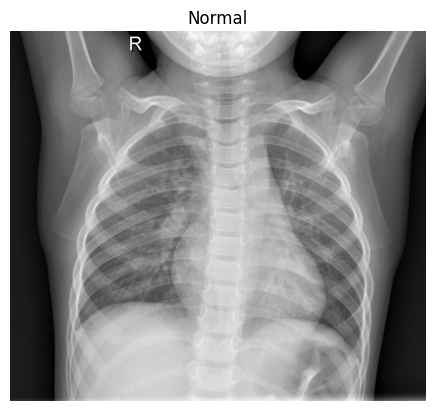

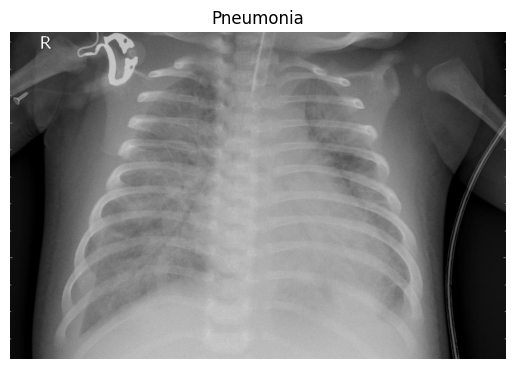

In [25]:
# Display a sample image for normal annd pneumonia
sample_image_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis('off')
plt.title("Normal")
plt.show()
sample_image_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis('off')
plt.title("Pneumonia")
plt.show()



In [26]:
hhh

NameError: name 'hhh' is not defined

In [27]:
import torch

def check_gpu():
    if torch.cuda.is_available():
        print(f"GPU est disponible: {torch.cuda.get_device_name(0)}")
    else:
        print("Aucun GPU disponible, utilisation du CPU")

check_gpu()


GPU est disponible: NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image
import random
import os

# Vérifier si le GPU est disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

Utilisation de: cuda:0


In [30]:
# Chemin vers les données
data_root = r"C:\Users\darck\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"  # Remplacez par le chemin réel de votre dataset
data_dir = data_root  # Utiliser data_root comme chemin racine

# Transformations d'images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Charger les données
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_root, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Créer des DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

# Tailles des ensembles de données
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")
print(f"Nombre d'images - Train: {dataset_sizes['train']}, Validation: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

Classes: ['NORMAL', 'PNEUMONIA']
Nombre d'images - Train: 5216, Validation: 16, Test: 624


In [32]:
from torchvision.transforms import functional as F
import random

# Calculer la différence entre les deux classes
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
augmentation_count = num_pneumonia - num_normal

print(f"Nombre d'images à augmenter pour équilibrer les classes: {augmentation_count}")

# Charger les images de la classe NORMAL
normal_dir = os.path.join(train_dir, 'NORMAL')
normal_images = os.listdir(normal_dir)
normal_images = [os.path.join(normal_dir, img) for img in normal_images]

# Fonction pour appliquer des augmentations
def augment_image(image):
    # Appliquer des transformations aléatoires
    if random.random() > 0.5:
        image = F.hflip(image)  # Inversion horizontale
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)  # Rotation aléatoire
        image = F.rotate(image, angle)
    if random.random() > 0.5:
        scale = random.uniform(0.8, 1.2)  # Zoom aléatoire
        image = F.affine(image, angle=0, translate=(0, 0), scale=scale, shear=0)
    return image

# Générer des images augmentées
augmented_images = []
for _ in range(augmentation_count):
    img_path = random.choice(normal_images)
    image = Image.open(img_path).convert('RGB')
    image = data_transforms['train'](image)  # Appliquer les transformations de base
    image = augment_image(image)  # Appliquer les augmentations
    augmented_images.append(image)

# Convertir en TensorDataset
augmented_images = torch.stack(augmented_images)
augmented_labels = torch.zeros(len(augmented_images))  # Labels pour NORMAL
augmented_dataset = torch.utils.data.TensorDataset(augmented_images, augmented_labels)

# Ajouter au DataLoader d'origine
normal_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)
print(f"Augmentation terminée. Nombre total d'images augmentées: {len(augmented_images)}")


Nombre d'images à augmenter pour équilibrer les classes: 2534
Augmentation terminée. Nombre total d'images augmentées: 2534


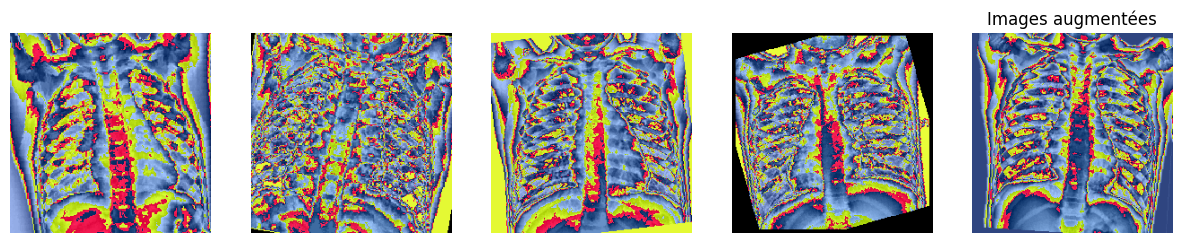

In [ ]:
# Afficher quelques images augmentées

# Fonction pour afficher des images
def show_images(images, title=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img in zip(axes, images):
        ax.imshow(F.to_pil_image(img))
        ax.axis('off')
    if title:
        plt.title(title)
    plt.show()
# Afficher quelques images augmentées
augmented_images_to_show = random.sample(list(augmented_images), 5)
show_images(augmented_images_to_show, title="Images augmentées")


In [35]:
# Fonction pour créer le modèle basé sur ResNet34
def create_model():
    # Charger ResNet34 pré-entraîné
    model = models.resnet34(weights='IMAGENET1K_V1')
    
    # Geler les premiers layers pour le transfert learning
    for param in list(model.parameters())[:-8]:  # Ne pas geler les derniers layers
        param.requires_grad = False
    
    # Modifier la dernière couche fully connected pour notre classification binaire
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),  # Augmenter à 256 neurones
        nn.BatchNorm1d(256),       # Ajouter une normalisation par batch
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)          # 2 classes: Normal et Pneumonie
    )
    
    return model

# Fonction d'entraînement
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stop_counter = 0  # Compteur pour le mécanisme d'early stopping
    
    # Pour suivre les métriques
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Chaque epoch a une phase d'entraînement et de validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Mode entraînement
            else:
                model.eval()   # Mode évaluation
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Itérer sur les données
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Réinitialiser les gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize seulement en phase d'entraînement
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistiques
                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(all_labels, all_preds)
            
            # Enregistrer les métriques
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Copier le modèle si c'est le meilleur
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    early_stop_counter = 0  # Réinitialiser le compteur d'early stopping
                else:
                    early_stop_counter += 1  # Incrémenter le compteur d'early stopping
        
        print()
        
        # Vérifier si le critère d'early stopping est atteint
        if early_stop_counter >= patience:
            print("Early stopping déclenché.")
            break
    
    # Charger les meilleurs poids du modèle
    model.load_state_dict(best_model_wts)
    return model, history

# Fonction pour évaluer sur l'ensemble de test
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculer les métriques
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\nRésultats sur l'ensemble de test:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Fonction pour visualiser l'évolution de l'entraînement
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Évolution de la perte')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Évolution de la précision')
    plt.xlabel('Epochs')
    plt.ylabel('Précision')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

Epoch 1/30
----------
train Loss: 0.1581 Acc: 0.9365
val Loss: 0.1297 Acc: 0.9375

Epoch 2/30
----------
train Loss: 0.1170 Acc: 0.9571
val Loss: 0.4723 Acc: 0.7500

Epoch 3/30
----------
train Loss: 0.0958 Acc: 0.9632
val Loss: 0.2211 Acc: 0.8750

Epoch 4/30
----------
train Loss: 0.0970 Acc: 0.9643
val Loss: 0.2902 Acc: 0.8125

Epoch 5/30
----------
train Loss: 0.0768 Acc: 0.9716
val Loss: 0.0908 Acc: 1.0000

Epoch 6/30
----------
train Loss: 0.0669 Acc: 0.9749
val Loss: 0.2429 Acc: 0.8125

Epoch 7/30
----------
train Loss: 0.0601 Acc: 0.9778
val Loss: 0.2890 Acc: 0.8125

Epoch 8/30
----------
train Loss: 0.0510 Acc: 0.9824
val Loss: 0.2438 Acc: 0.8125

Epoch 9/30
----------
train Loss: 0.0549 Acc: 0.9793
val Loss: 0.3624 Acc: 0.6875

Epoch 10/30
----------
train Loss: 0.0565 Acc: 0.9810
val Loss: 0.3203 Acc: 0.6875

Epoch 11/30
----------
train Loss: 0.0486 Acc: 0.9826
val Loss: 0.2977 Acc: 0.7500

Epoch 12/30
----------
train Loss: 0.0532 Acc: 0.9820
val Loss: 0.3241 Acc: 0.7500

E

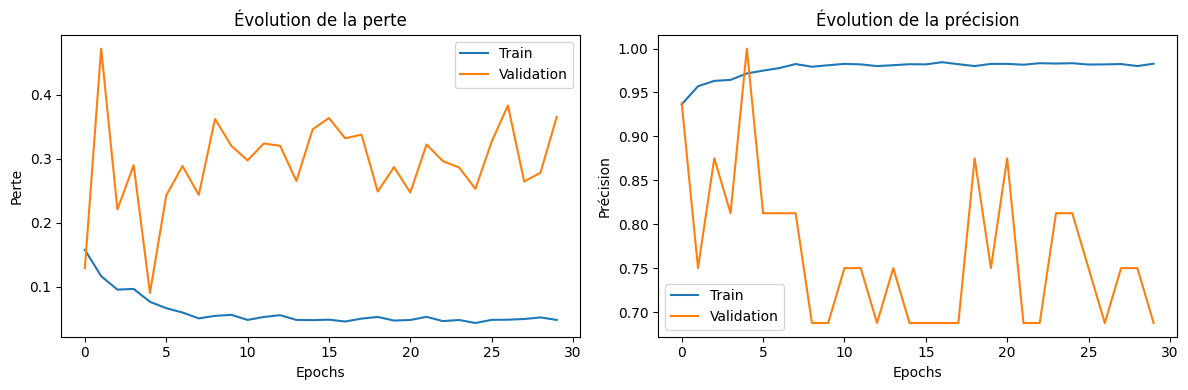

Modèle sauvegardé avec succès.


In [ ]:
if __name__ == "__main__":
    # Créer le modèle
    model = create_model()
    model = model.to(device)
    
    # Définir la fonction de perte et l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Scheduler pour réduire le learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # Entraîner le modèle
    model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=30)
    
    # Évaluer sur l'ensemble de test
    evaluate_model(model)
    
    # Visualiser l'évolution de l'entraînement
    plot_training_history(history)
    
    # Sauvegarder le modèle
    torch.save(model.state_dict(), '1pneumonia_resnet34.pth')
    print("Modèle sauvegardé avec succès.")

In [ ]:
#importer le modèle sauvegardé "densenet_pneumonia_model.pth" et faire une prédiction sur une image
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# Charger le modèle
# Charger le modèle
model = create_model()  # Assurez-vous que create_model() correspond à l'architecture utilisée pour entraîner le modèle
state_dict = torch.load('1pneumonia_resnet34.pth')

# Charger uniquement les clés correspondantes
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k in model.state_dict() and model.state_dict()[k].shape == v.shape:
        new_state_dict[k] = v
    else:
        print(f"Skipping key: {k} due to shape mismatch or missing key.")

model.load_state_dict(new_state_dict, strict=False)
model.eval()
model.to(device)

#afficher la probabilité de chaque classe


# Fonction pour prédire une image
def predict_image(image_path):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')
    
    # Appliquer les transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch
    
    # Prédire
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    #afficher la probabilité de chaque classe
    probs = torch.softmax(outputs, dim=1)
    probs = probs.cpu().numpy()
    print(f"Probabilités: {probs}")
    print(f"Prédictions: {preds}")
    

    return preds.item()






Skipping key: fc.0.weight due to shape mismatch or missing key.
Skipping key: fc.0.bias due to shape mismatch or missing key.
Skipping key: fc.3.weight due to shape mismatch or missing key.
Skipping key: fc.3.bias due to shape mismatch or missing key.


Probabilités: [[0.4796565  0.52034354]]
Prédictions: tensor([1], device='cuda:0')
Classe prédite: PNEUMONIA


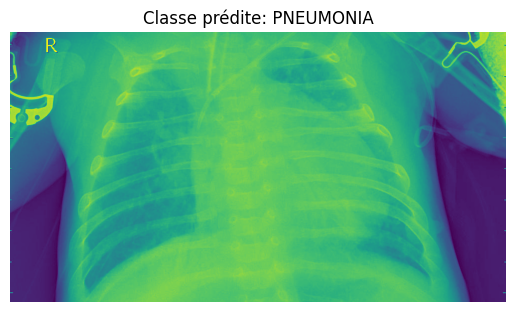

In [ ]:
# Chemin de l'image à prédire
image_path = r"C:\Users\darck\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg" # Remplacez par le chemin de votre image

# Prédire l'image
predicted_class = predict_image(image_path)
print(f"Classe prédite: {class_names[predicted_class]}")

# Afficher l'image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Classe prédite: {class_names[predicted_class]}")
plt.axis('off')
plt.show()